In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
import plotly.express as px
import math

# Data Normalization, Export to SQLite3

In [2]:
df_adult_mort = pd.read_csv('archive/Adult mortality.csv')
df_maternal_mort = pd.read_csv('archive/Maternal mortality.csv')
df_num_deaths = pd.read_csv('archive/Number of deaths (thousands).csv')
df_prob_dying = pd.read_csv('archive/Probability of dying per 1000 live births.csv')

In [3]:
def change_dtypes(df,num_type = int):
    # change numbers to int, country names to str
    for col_name in df.columns:
        if col_name == 'Country':
            df = df.astype({col_name: str})
        elif col_name == 'Year':
            df = df.astype({col_name: int})
        else:
            df = df.astype({col_name: num_type})
    print(df.dtypes)
    return df

### Adult mortality rate

In [4]:
df_adult_mort = df_adult_mort.iloc[1: , :]
df_adult_mort.rename(columns={'Unnamed: 0': 'Country', 'Unnamed: 1': 'Year',
                           'Adult mortality rate (probability of dying between 15 and 60 years per 1000 population)': 'adult_mort_per_1000_both',
                           'Adult mortality rate (probability of dying between 15 and 60 years per 1000 population).1': 'adult_mort_per_1000_male',
                           'Adult mortality rate (probability of dying between 15 and 60 years per 1000 population).2': 'adult_mort_per_1000_female'}, 
                  inplace=True)
df_adult_mort = change_dtypes(df_adult_mort)
df_adult_mort = df_adult_mort.sort_values(by=['Country', 'Year'],ascending=True)
df_adult_mort.head()

Country                       object
Year                           int64
adult_mort_per_1000_both       int64
adult_mort_per_1000_male       int64
adult_mort_per_1000_female     int64
dtype: object


Country  Year  adult_mort_per_1000_both  adult_mort_per_1000_male  \
17  Afghanistan  2000                       316                       340   
16  Afghanistan  2001                       307                       330   
15  Afghanistan  2002                       292                       309   
14  Afghanistan  2003                       286                       304   
13  Afghanistan  2004                       282                       300   

    adult_mort_per_1000_female  
17                         290  
16                         283  
15                         275  
14                         268  
13                         263

In [5]:
conn = sql.connect('adult_mort')
c = conn.cursor()
df_adult_mort.to_sql('adult_mort', conn, if_exists='replace', index = False) # save dataframe to sqlite3 database

### Maternal mortality rate

In [6]:
df_maternal_mort.head()

Country  Year Maternal mortality ratio (per 100 000 live births)  \
0  Afghanistan  2017                                638 [ 427 - 1 010 ]   
1  Afghanistan  2016                                673 [ 457 - 1 040 ]   
2  Afghanistan  2015                                701 [ 501 - 1 020 ]   
3  Afghanistan  2014                                786 [ 592 - 1 080 ]   
4  Afghanistan  2013                                810 [ 617 - 1 080 ]   

  Number of maternal deaths  
0  7 700 [ 5 100 - 12 000 ]  
1  8 100 [ 5 500 - 12 000 ]  
2  8 400 [ 6 000 - 12 000 ]  
3  9 300 [ 7 000 - 13 000 ]  
4  9 600 [ 7 300 - 13 000 ]

In [7]:
df_maternal_mort.rename(columns={'Maternal mortality ratio (per 100 000 live births)': 'Maternal_mort_per_100000', 
                              'Number of maternal deaths': 'Maternal_mort_number'}, 
                  inplace=True)
df_maternal_mort = df_maternal_mort.sort_values(by=['Country', 'Year'],ascending=True)

In [8]:
# split the "Maternal mortality ratio" column to three columns
listmr = df_maternal_mort["Maternal_mort_per_100000"].tolist()
listmr = [i.replace(' ','') for i in listmr]
meanmr = [int(i.split('[')[0]) for i in listmr]
minmr = [int(i.split('[')[1].split('-')[0]) for i in listmr]
maxmr = [int(i.split('[')[1].split('-')[1].replace(']','')) for i in listmr]
df_maternal_mort["Mean_Maternal_mort_per_100000"] = meanmr
df_maternal_mort["Max_Maternal_mort_per_100000"] = maxmr
df_maternal_mort["Min_Maternal_mort_per_100000"] = minmr
df_maternal_mort = df_maternal_mort.drop(["Maternal_mort_per_100000"], axis=1)

# split the "Number of maternal deaths" column to three columns
listmd = df_maternal_mort["Maternal_mort_number"].tolist()
listmd = [i.replace(' ','') for i in listmd]
meanmd = []
minmd = []
maxmd = []
for i in listmd:
    try:
        mean_i = int(i.split('[')[0])
        min_i = int(i.split('[')[1].split('-')[0])
        max_i = int(i.split('[')[1].split('-')[1].replace(']',''))
    except ValueError: # some countries has zero maternal death number
        mean_i = 0
        min_i = 0
        max_i = 0
    meanmd.append(mean_i)
    minmd.append(min_i)
    maxmd.append(max_i)
df_maternal_mort["Mean_Maternal_mort_number"] = meanmd
df_maternal_mort["Max_Maternal_mort_number"] = maxmd
df_maternal_mort["Min_Maternal_mort_number"] = minmd
df_maternal_mort = df_maternal_mort.drop(["Maternal_mort_number"], axis=1)

In [9]:
df_maternal_mort.head()

Country  Year  Mean_Maternal_mort_per_100000  \
17  Afghanistan  2000                           1450   
16  Afghanistan  2001                           1390   
15  Afghanistan  2002                           1300   
14  Afghanistan  2003                           1240   
13  Afghanistan  2004                           1180   

    Max_Maternal_mort_per_100000  Min_Maternal_mort_per_100000  \
17                          1840                          1030   
16                          1760                           994   
15                          1640                           944   
14                          1540                           909   
13                          1460                           878   

    Mean_Maternal_mort_number  Max_Maternal_mort_number  \
17                      15000                     19000   
16                      15000                     18000   
15                      14000                     18000   
14                      14000                     17000   
13                      13000                     16000   

    Min_Maternal_mort_number  
17                     11000  
16                     10000  
15                     10000  
14                      9900  
13                      9800

In [10]:
conn = sql.connect('maternal_mort')
c = conn.cursor()
df_maternal_mort.to_sql('maternal_mort', conn, if_exists='replace', index = False)

### Children mortality rate

In [11]:
df_num_deaths = df_num_deaths.iloc[1: , :]
df_num_deaths.rename(columns={'Unnamed: 0': 'Country', 'Unnamed: 1': 'Year'}, inplace=True)
df_num_deaths = change_dtypes(df_num_deaths)

df_num_deaths.head()

Country                                      object
Year                                          int64
Number of under-five deaths (thousands)       int64
Number of under-five deaths (thousands).1     int64
Number of under-five deaths (thousands).2     int64
Number of infant deaths (thousands)           int64
Number of infant deaths (thousands).1         int64
Number of infant deaths (thousands).2         int64
Number of neonatal deaths (thousands)         int64
dtype: object


Country  Year  Number of under-five deaths (thousands)  \
1  Afghanistan  2018                                    74278   
2  Afghanistan  2017                                    76877   
3  Afghanistan  2016                                    79770   
4  Afghanistan  2015                                    82918   
5  Afghanistan  2014                                    86378   

   Number of under-five deaths (thousands).1  \
1                                      40312   
2                                      41631   
3                                      43134   
4                                      44733   
5                                      46509   

   Number of under-five deaths (thousands).2  \
1                                      33966   
2                                      35246   
3                                      36636   
4                                      38185   
5                                      39869   

   Number of infant deaths (thousands)  Number of infant deaths (thousands).1  \
1                                57182                                  31394   
2                                58846                                  32244   
3                                60673                                  33222   
4                                62652                                  34257   
5                                64808                                  35410   

   Number of infant deaths (thousands).2  \
1                                  25788   
2                                  26602   
3                                  27451   
4                                  28395   
5                                  29398   

   Number of neonatal deaths (thousands)  
1                                  44725  
2                                  45771  
3                                  46963  
4                                  48237  
5                                  49715

In [12]:
df_prob_dying = df_prob_dying.iloc[1: , :]
df_prob_dying.rename(columns={'Unnamed: 0': 'Country', 'Unnamed: 1': 'Year'}, inplace=True)
df_prob_dying = change_dtypes(df_prob_dying, num_type = np.float64)
df_prob_dying.head()

Country                                                                                         object
Year                                                                                             int64
Infant mortality rate (probability of dying between birth and age 1 per 1000 live births)      float64
Infant mortality rate (probability of dying between birth and age 1 per 1000 live births).1    float64
Infant mortality rate (probability of dying between birth and age 1 per 1000 live births).2    float64
Neonatal mortality rate (per 1000 live births)                                                 float64
Under-five mortality rate (probability of dying by age 5 per 1000 live births)                 float64
Under-five mortality rate (probability of dying by age 5 per 1000 live births).1               float64
Under-five mortality rate (probability of dying by age 5 per 1000 live births).2               float64
dtype: object


Country  Year  \
1  Afghanistan  2018   
2  Afghanistan  2017   
3  Afghanistan  2016   
4  Afghanistan  2015   
5  Afghanistan  2014   

   Infant mortality rate (probability of dying between birth and age 1 per 1000 live births)  \
1                                               47.9                                           
2                                               49.5                                           
3                                               51.2                                           
4                                               53.1                                           
5                                               55.1                                           

   Infant mortality rate (probability of dying between birth and age 1 per 1000 live births).1  \
1                                               51.1                                             
2                                               52.7                                             
3                                               54.5                                             
4                                               56.5                                             
5                                               58.6                                             

   Infant mortality rate (probability of dying between birth and age 1 per 1000 live births).2  \
1                                               44.5                                             
2                                               46.0                                             
3                                               47.7                                             
4                                               49.6                                             
5                                               51.5                                             

   Neonatal mortality rate (per 1000 live births)  \
1                                            37.1   
2                                            38.1   
3                                            39.3   
4                                            40.5   
5                                            41.9   

   Under-five mortality rate (probability of dying by age 5 per 1000 live births)  \
1                                               62.3                                
2                                               64.7                                
3                                               67.5                                
4                                               70.4                                
5                                               73.6                                

   Under-five mortality rate (probability of dying by age 5 per 1000 live births).1  \
1                                               65.7                                  
2                                               68.1                                  
3                                               70.9                                  
4                                               73.8                                  
5                                               77.0                                  

   Under-five mortality rate (probability of dying by age 5 per 1000 live births).2  
1                                               58.7                                 
2                                               61.1                                 
3                                               63.7                                 
4                                               66.7                                 
5                                               69.9

In [13]:
df_children_mort = pd.merge(df_num_deaths, df_prob_dying, on=['Country', 'Year'])
df_children_mort = df_children_mort.sort_values(by=['Country', 'Year'],ascending=True)
df_children_mort.head()

Country  Year  Number of under-five deaths (thousands)  \
5  Afghanistan  2013                                    90103   
4  Afghanistan  2014                                    86378   
3  Afghanistan  2015                                    82918   
2  Afghanistan  2016                                    79770   
1  Afghanistan  2017                                    76877   

   Number of under-five deaths (thousands).1  \
5                                      48461   
4                                      46509   
3                                      44733   
2                                      43134   
1                                      41631   

   Number of under-five deaths (thousands).2  \
5                                      41642   
4                                      39869   
3                                      38185   
2                                      36636   
1                                      35246   

   Number of infant deaths (thousands)  Number of infant deaths (thousands).1  \
5                                67154                                  36656   
4                                64808                                  35410   
3                                62652                                  34257   
2                                60673                                  33222   
1                                58846                                  32244   

   Number of infant deaths (thousands).2  \
5                                  30498   
4                                  29398   
3                                  28395   
2                                  27451   
1                                  26602   

   Number of neonatal deaths (thousands)  \
5                                  51219   
4                                  49715   
3                                  48237   
2                                  46963   
1                                  45771   

   Infant mortality rate (probability of dying between birth and age 1 per 1000 live births)  \
5                                               57.3                                           
4                                               55.1                                           
3                                               53.1                                           
2                                               51.2                                           
1                                               49.5                                           

   Infant mortality rate (probability of dying between birth and age 1 per 1000 live births).1  \
5                                               60.8                                             
4                                               58.6                                             
3                                               56.5                                             
2                                               54.5                                             
1                                               52.7                                             

   Infant mortality rate (probability of dying between birth and age 1 per 1000 live births).2  \
5                                               53.6                                             
4                                               51.5                                             
3                                               49.6                                             
2                                               47.7                                             
1                                               46.0                                             

   Neonatal mortality rate (per 1000 live births)  \
5                                            43.3   
4                                            41.9   
3                                            40.5   
2                                            39.3   
1

In [14]:
df_children_mort.rename(columns={'Number of under-five deaths (thousands)': 'Under_five_death_number(thousands)_both', 
                              'Number of under-five deaths (thousands).1': 'Under_five_death_number(thousands)_male',
                              'Number of under-five deaths (thousands).2': 'Under_five_death_number(thousands)_female',
                              'Number of infant deaths (thousands)': 'Infant_death_number(thousands)_both',
                              'Number of infant deaths (thousands).1': 'Infant_death_number(thousands)_male',
                              'Number of infant deaths (thousands).2': 'Infant_death_number(thousands)_female',
                              'Number of neonatal deaths (thousands)': 'Neonatal_death_number(thousands)',
                              'Under-five mortality rate (probability of dying by age 5 per 1000 live births)':\
                              'Under_five_mort_per_1000_both',
                              'Under-five mortality rate (probability of dying by age 5 per 1000 live births).1':\
                              'Under_five_mort_per_1000_male',
                              'Under-five mortality rate (probability of dying by age 5 per 1000 live births).2':\
                              'Under_five_mort_per_1000_female',
                              'Infant mortality rate (probability of dying between birth and age 1 per 1000 live births)': \
                              'Infant_mort_per_1000_both',
                              'Infant mortality rate (probability of dying between birth and age 1 per 1000 live births).1': \
                              'Infant_mort_per_1000_male',
                              'Infant mortality rate (probability of dying between birth and age 1 per 1000 live births).2': \
                              'Infant_mort_per_1000_female',
                              'Neonatal mortality rate (per 1000 live births)': 'Neonatal_mort_per_1000'
                             
                             }, inplace=True)

In [15]:
df_children_mort.head()

Country  Year  Under_five_death_number(thousands)_both  \
5  Afghanistan  2013                                    90103   
4  Afghanistan  2014                                    86378   
3  Afghanistan  2015                                    82918   
2  Afghanistan  2016                                    79770   
1  Afghanistan  2017                                    76877   

   Under_five_death_number(thousands)_male  \
5                                    48461   
4                                    46509   
3                                    44733   
2                                    43134   
1                                    41631   

   Under_five_death_number(thousands)_female  \
5                                      41642   
4                                      39869   
3                                      38185   
2                                      36636   
1                                      35246   

   Infant_death_number(thousands)_both  Infant_death_number(thousands)_male  \
5                                67154                                36656   
4                                64808                                35410   
3                                62652                                34257   
2                                60673                                33222   
1                                58846                                32244   

   Infant_death_number(thousands)_female  Neonatal_death_number(thousands)  \
5                                  30498                             51219   
4                                  29398                             49715   
3                                  28395                             48237   
2                                  27451                             46963   
1                                  26602                             45771   

   Infant_mort_per_1000_both  Infant_mort_per_1000_male  \
5                       57.3                       60.8   
4                       55.1                       58.6   
3                       53.1                       56.5   
2                       51.2                       54.5   
1                       49.5                       52.7   

   Infant_mort_per_1000_female  Neonatal_mort_per_1000  \
5                         53.6                    43.3   
4                         51.5                    41.9   
3                         49.6                    40.5   
2                         47.7                    39.3   
1                         46.0                    38.1   

   Under_five_mort_per_1000_both  Under_five_mort_per_1000_male  \
5                           76.9                           80.5   
4                           73.6                           77.0   
3                           70.4                           73.8   
2                           67.5                           70.9   
1                           64.7                           68.1   

   Under_five_mort_per_1000_female  
5                             73.2  
4                             69.9  
3                             66.7  
2                             63.7  
1                             61.1

In [16]:
conn = sql.connect('children_mort')
c = conn.cursor()
df_children_mort.to_sql('children_mort', conn, if_exists='replace', index = False)

# Load from Database, Visualization

In [17]:
def get_country_adult_mort(countryname):
    conn = sql.connect('adult_mort')
    c = conn.cursor()
    data = c.execute("SELECT * FROM adult_mort WHERE Country = ?", (countryname,))
    df = pd.DataFrame(c.fetchall(),columns = [description[0] for description in data.description])
    return df

In [18]:
def get_year_adult_mort(year):
    conn = sql.connect('adult_mort')
    c = conn.cursor()
    data = c.execute("SELECT * FROM adult_mort WHERE Year = ?", (year,))
    df = pd.DataFrame(c.fetchall(),columns = [description[0] for description in data.description])
    return df

In [19]:
shorten = {'United Republic of Tanzania': 'Tanzania',
           'Republic of North Macedonia': 'North Macedonia',
           'Democratic Republic of the Congo': 'Congo',
           'United States of Americ': 'USA',
           'Central African Republic': 'Central African',
           'Bolivia (Plurinational State of)': 'Bolivia',
           'Sao Tome and Principe': 'Sao T & P',
           "Democratic People's Republic of Korea": 'Korea',
           'Micronesia (Federated States of)': 'Micronesia',
           "Lao People's Democratic Republic": 'Lao',
           'Saint Vincent and the Grenadines': 'St. Vicent & Grenadines',
           'Venezuela (Bolivarian Republic of)': 'Venezuela',
           'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
           'Iran (Islamic Republic of)': 'Iran',
           'Bosnia and Herzegovina': 'Bosnia & Herzegovina'
          }

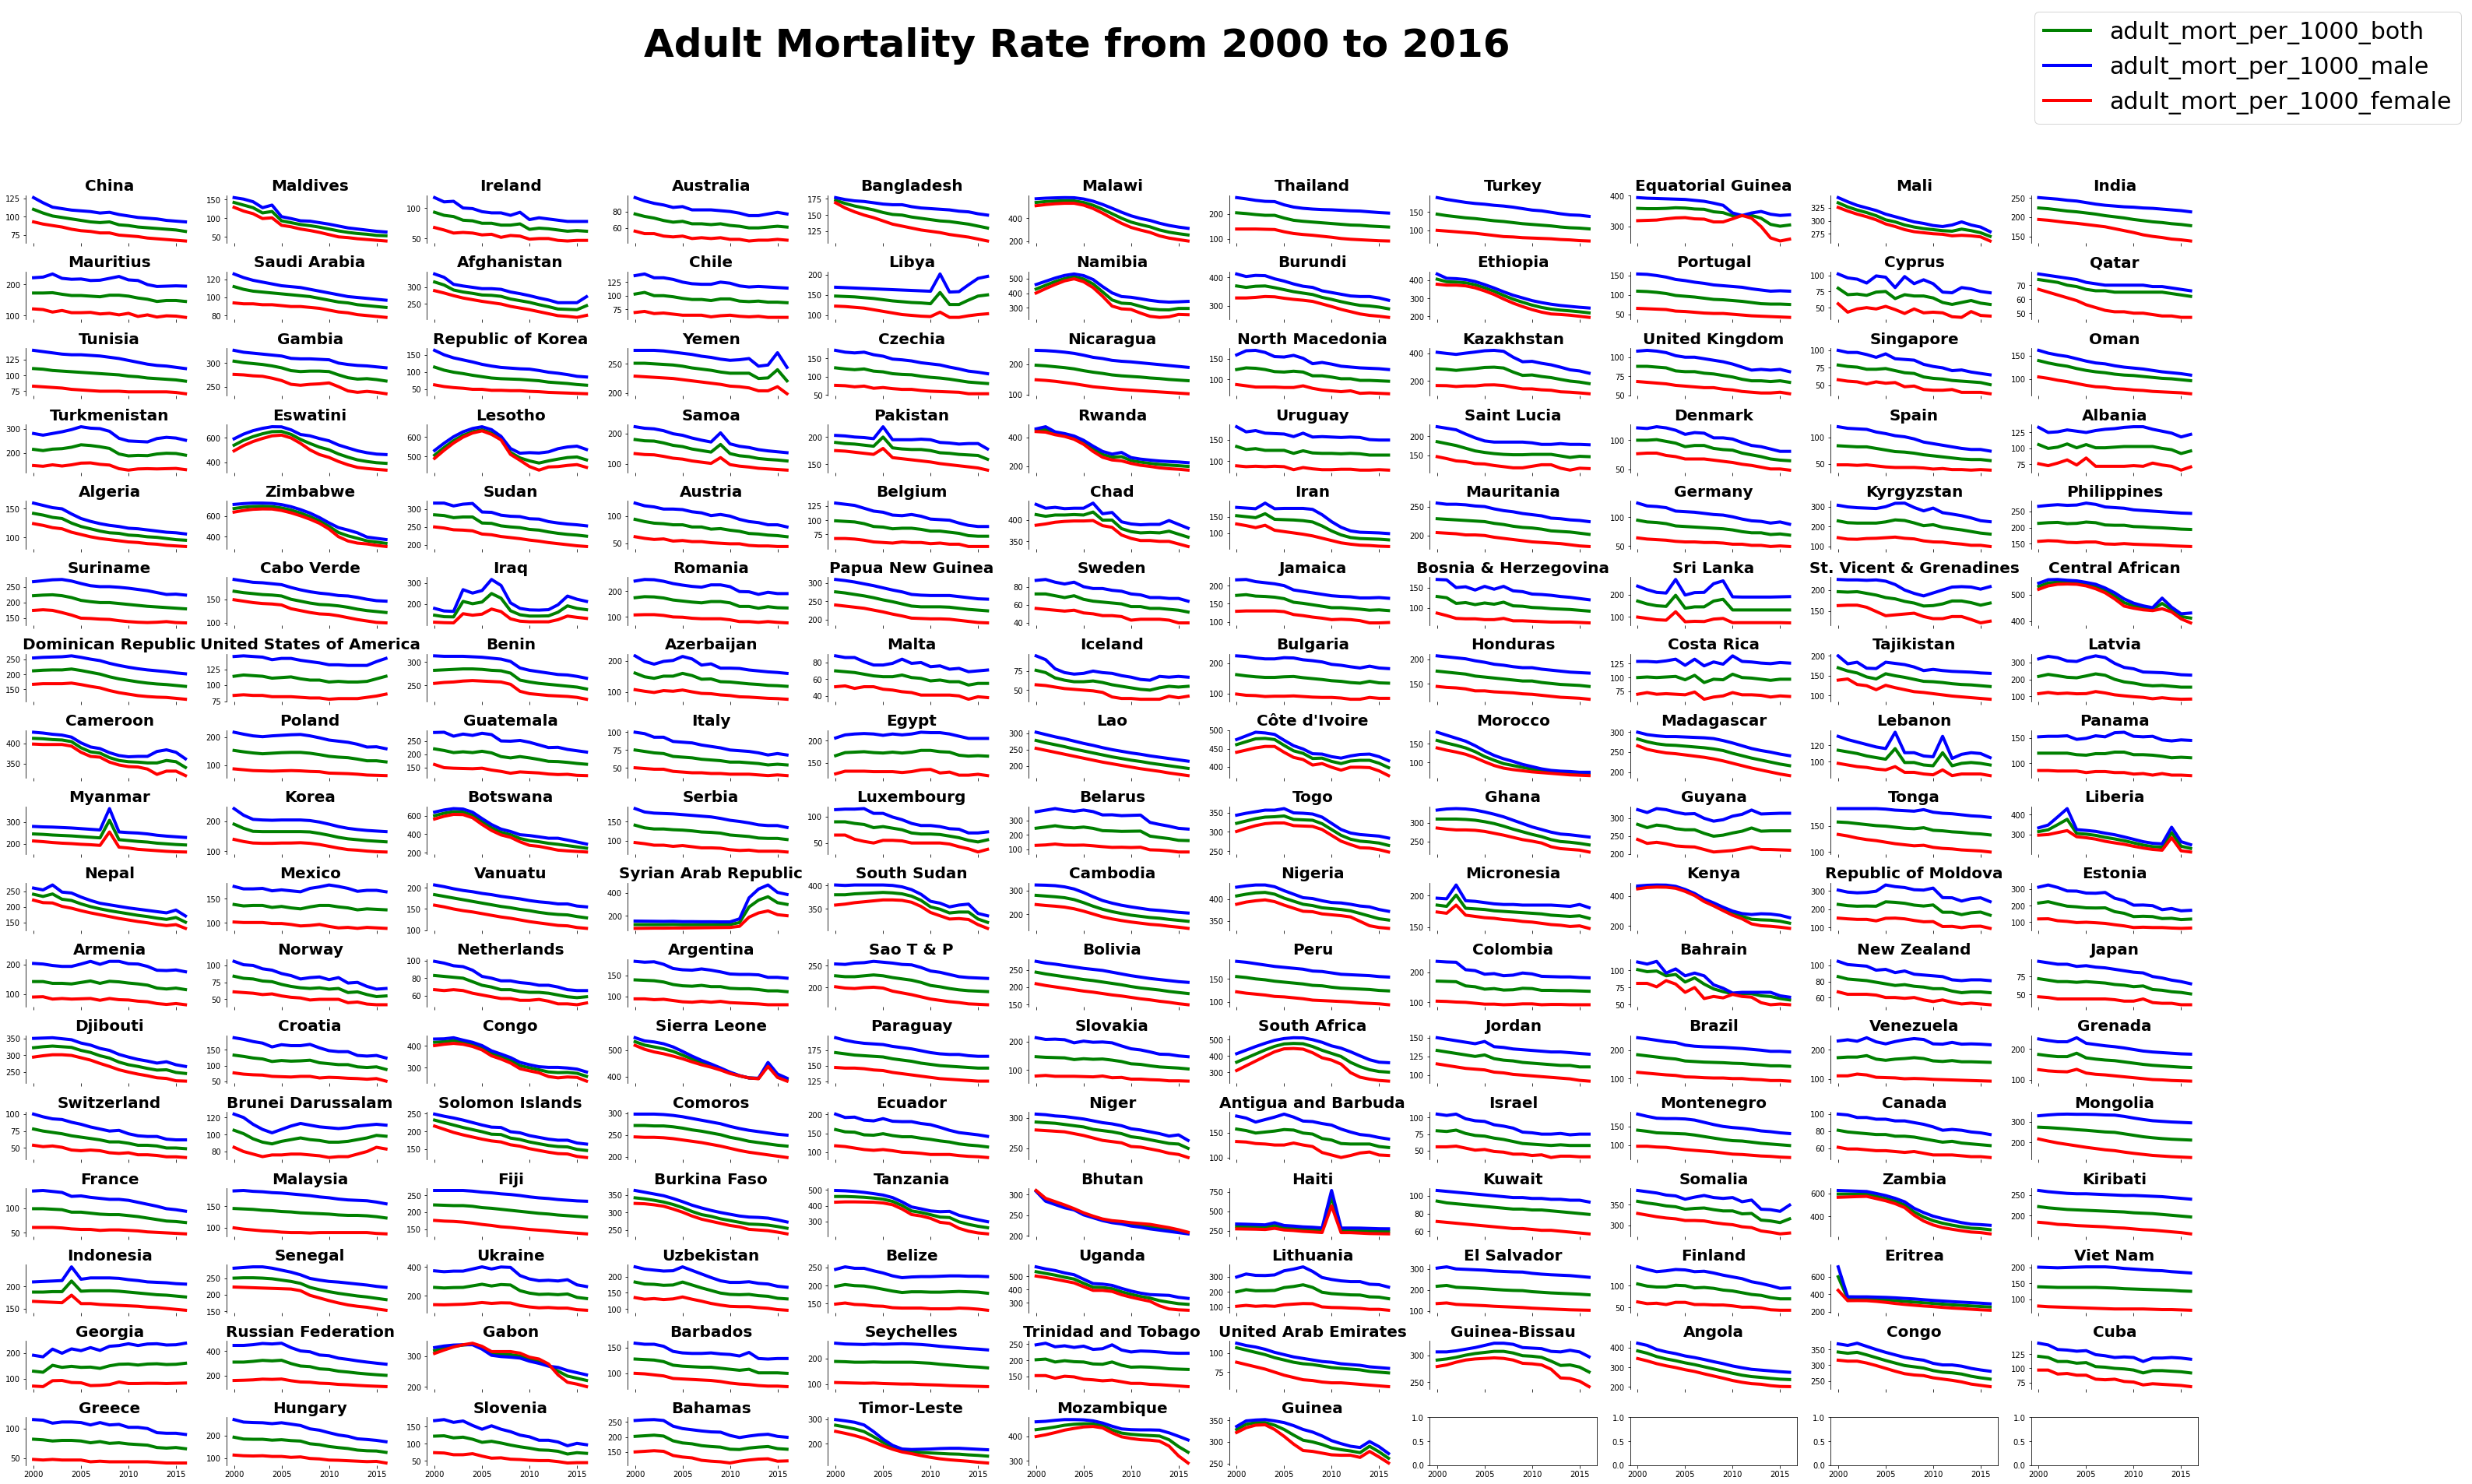

In [20]:
# Plot by country
conn = sql.connect('adult_mort')
c = conn.cursor()
countries = c.execute("SELECT Country FROM adult_mort")
countries = set(countries.fetchall())

# Calculate the number of subplots based on the number of countries
ncols = 11
nrows = math.ceil(len(countries) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(50, 30), sharex=True)
plt.subplots_adjust(hspace=0.6)
fig.suptitle("Adult Mortality Rate from 2000 to 2016", fontweight = "bold", fontsize=50)
colors = ['g','b','r']
for country, ax in zip(countries, axes.flatten()):
    country = country[0]
    df_country = get_country_adult_mort(country)  # Select by country name
    t = df_country['Year'].values.tolist()
    for i in range (2, df_country.shape[1]):
        ax.plot(t, df_country.iloc[:, i].values,
                linewidth=4,
                color = colors[i-2], 
                label = df_country.iloc[:, i].name)
        ax.set_title(shorten[country] if country in shorten else country,
                     fontweight="bold", size=20) # Title
        ax.grid(False)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',prop={'size': 30})
plt.show()

In [21]:
#plot on map
def plot_map_by_year(year, feature):
    year_df = get_year_adult_mort(year)
    fig = px.choropleth(year_df, locations="Country", 
                        locationmode='country names', 
                        color=feature, 
                        hover_name="Country", 
                        range_color=[np.percentile(year_df[feature],25),np.percentile(year_df[feature],75)], 
                        color_continuous_scale="blues", 
                        title = str(year) + ' ' +feature )
    
    fig.update(layout_coloraxis_showscale=True, layout_width = 1000, layout_height = 700)
    fig.show()
plot_map_by_year(2000, 'adult_mort_per_1000_both')

In [22]:
def get_country_maternal(countryname):
    conn = sql.connect('maternal_mort')
    c = conn.cursor()
    data = c.execute("SELECT * FROM maternal_mort WHERE Country = ?", (countryname,))
    df = pd.DataFrame(c.fetchall(),columns = [description[0] for description in data.description])
    return df

In [23]:
def get_year_maternal_mort(year):
    conn = sql.connect('maternal_mort')
    c = conn.cursor()
    data = c.execute("SELECT * FROM maternal_mort WHERE Year = ?", (year,))
    df = pd.DataFrame(c.fetchall(),columns = [description[0] for description in data.description])
    return df

In [24]:
# get country names
conn = sql.connect('maternal_mort')
c = conn.cursor()
countries = c.execute("SELECT Country FROM maternal_mort")
countries = set(countries.fetchall())

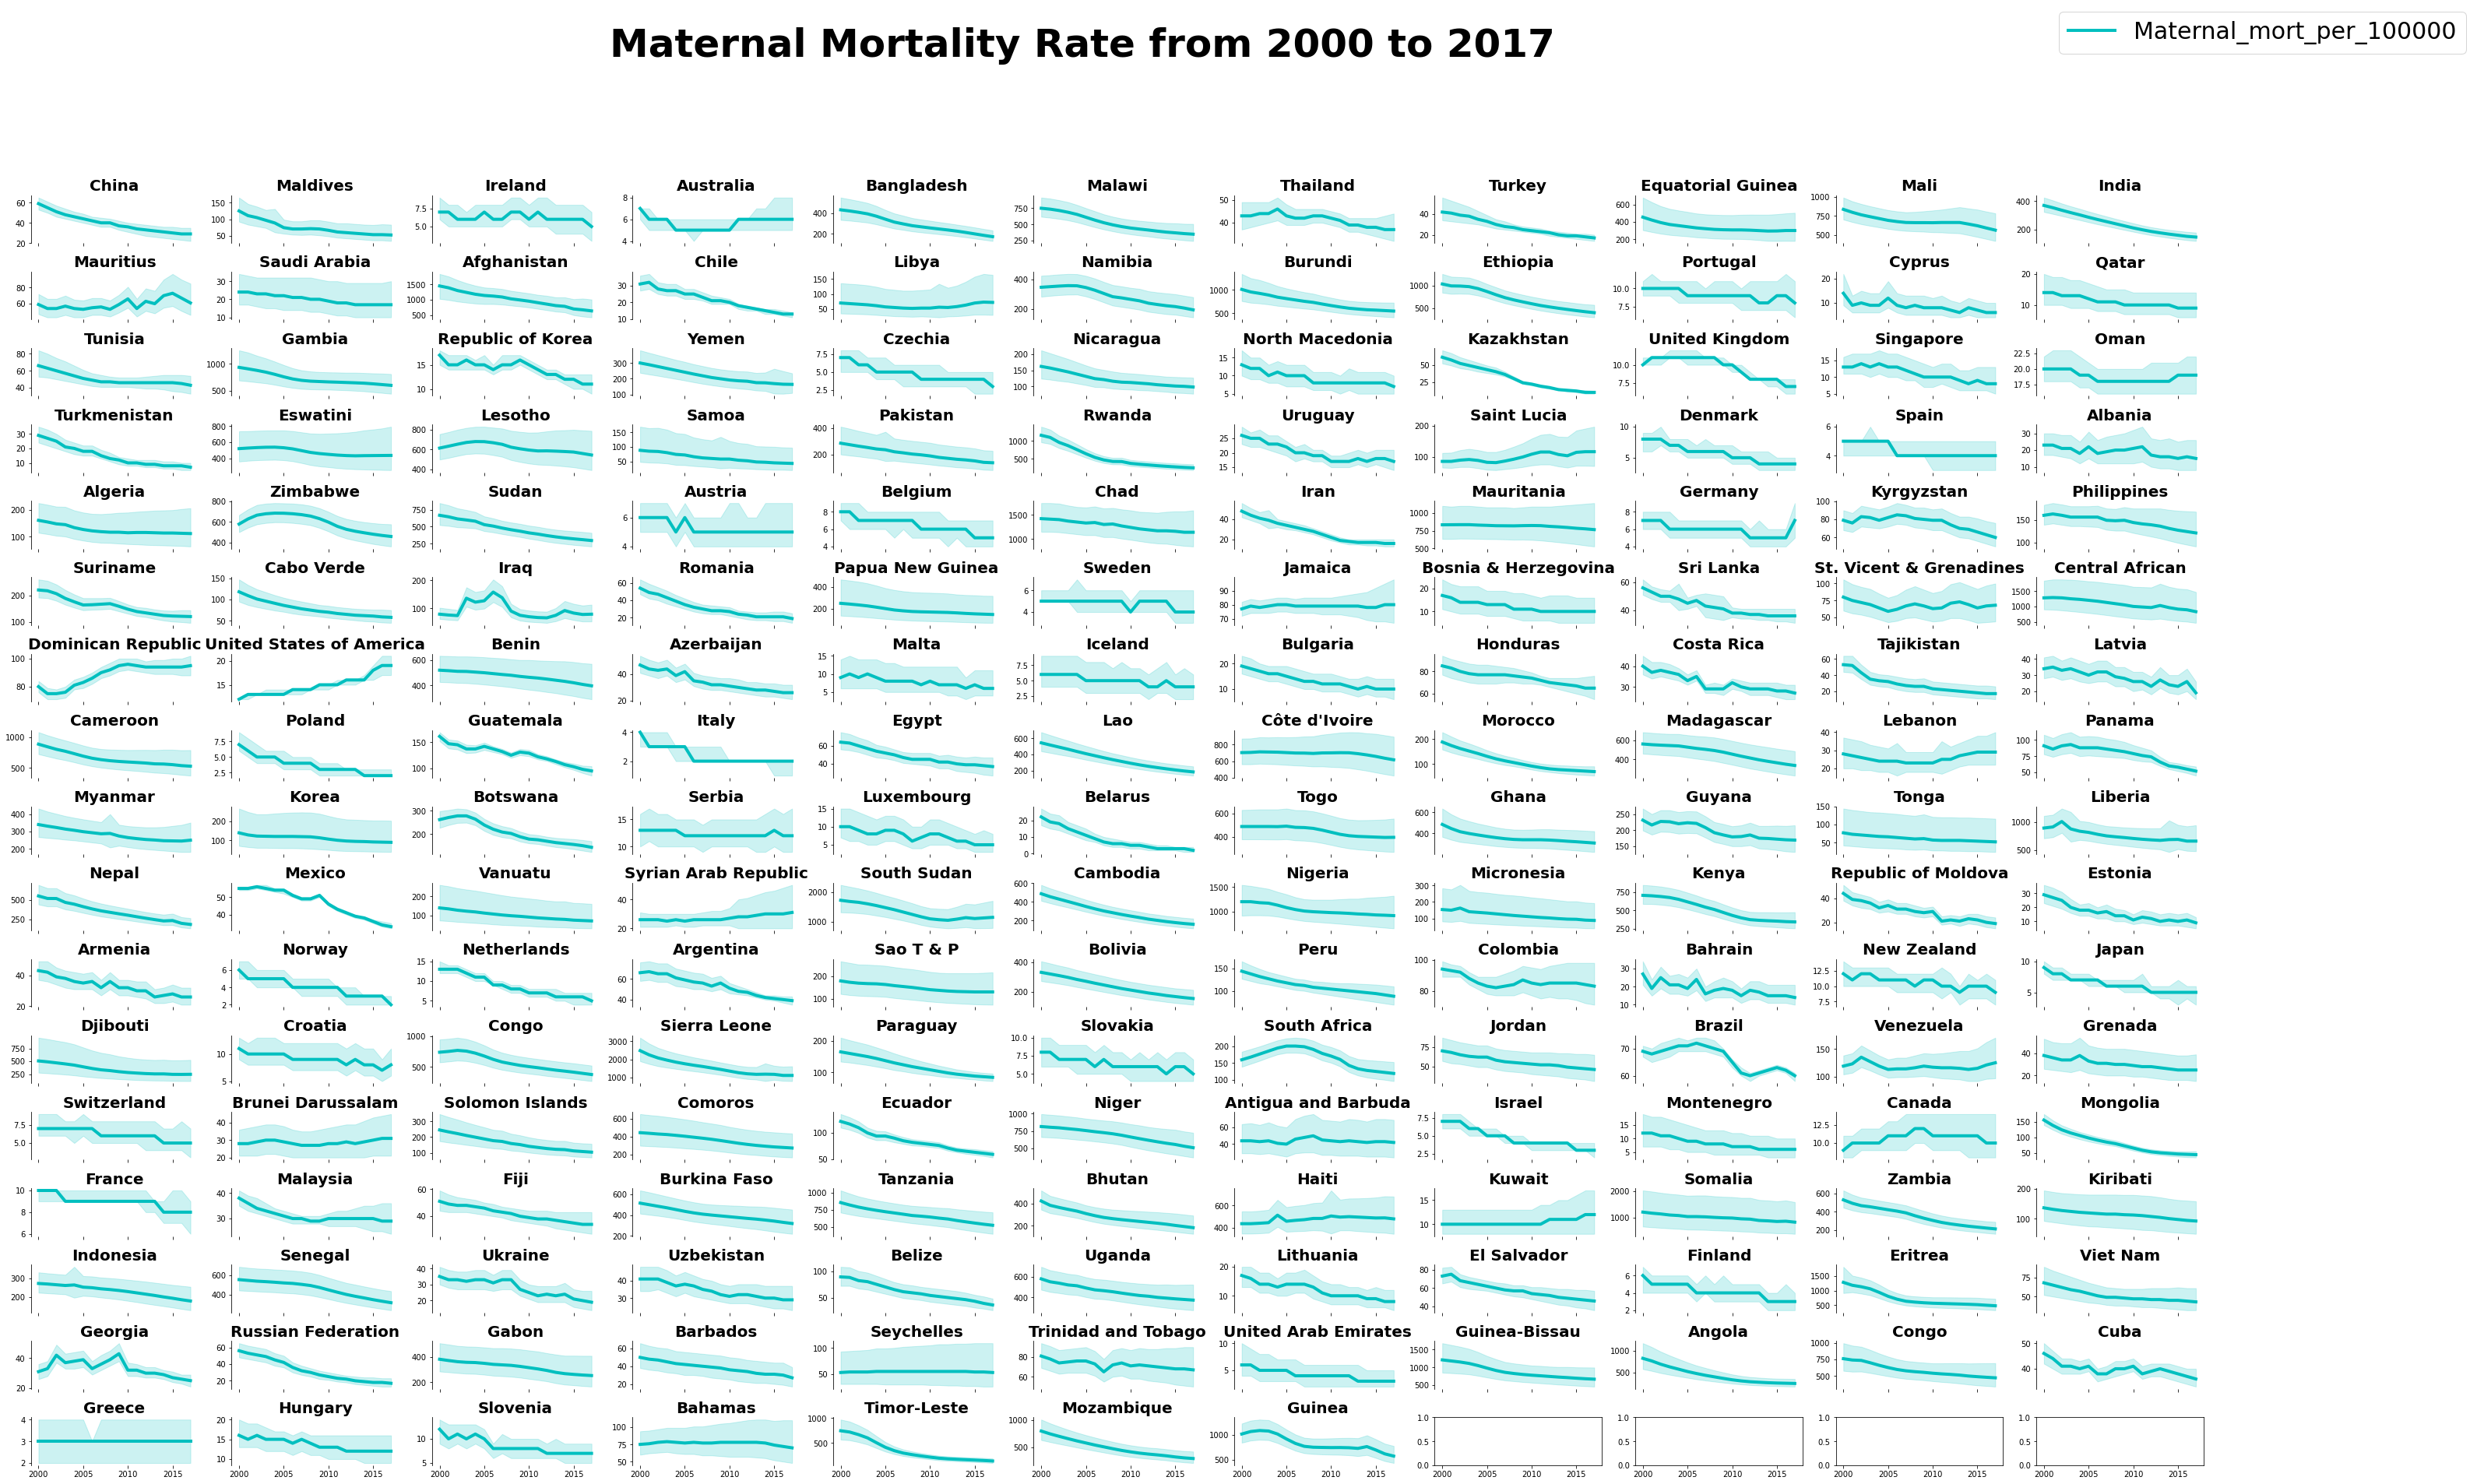

In [25]:
ncols = 11
nrows = math.ceil(len(countries) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(50, 30),sharex=True)
plt.subplots_adjust(hspace=0.6)
fig.suptitle("Maternal Mortality Rate from 2000 to 2017", fontweight = "bold", fontsize=50)

for country, ax in zip(countries, axes.flatten()):
    # Filter data for each country
    country = country[0] 
    df_country = get_country_maternal(country)  # Select by country name
    t = df_country['Year'].values.tolist()
    mean_rate = df_country['Mean_Maternal_mort_per_100000'].values
    max_rate = df_country['Max_Maternal_mort_per_100000'].values
    min_rate = df_country['Min_Maternal_mort_per_100000'].values
    ax.plot(t,mean_rate, linewidth = 4, color = 'c',
            label = 'Maternal_mort_per_100000')
    ax.fill_between(t,min_rate,max_rate,color = 'c',alpha=0.2)
    ax.set_title(shorten[country] if country in shorten else country, 
                 fontweight="bold", size=20) # Title
    ax.grid(False)
    #ax.axis('off')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',prop={'size': 30})
plt.show()

In [26]:
#plot on map
def plot_map_by_year(year, feature):
    year_df = get_year_maternal_mort(year)
    fig = px.choropleth(year_df, locations="Country", 
                        locationmode='country names', 
                        color=feature, 
                        hover_name="Country", 
                        range_color=[np.percentile(year_df[feature],25),np.percentile(year_df[feature],75)], 
                        color_continuous_scale="blues", 
                        title = str(year) + ' ' +feature )
    fig.update(layout_coloraxis_showscale=True, layout_width = 1000, layout_height = 700)
    fig.show()
plot_map_by_year(2000, 'Mean_Maternal_mort_per_100000')

In [27]:
def get_country_children(countryname):
    conn = sql.connect('children_mort')
    c = conn.cursor()
    data = c.execute("SELECT * FROM children_mort WHERE Country = ?", (countryname,))
    df = pd.DataFrame(c.fetchall(),columns = [description[0] for description in data.description])
    return df

In [28]:
def get_year_children(year):
    conn = sql.connect('children_mort')
    c = conn.cursor()
    data = c.execute("SELECT * FROM children_mort WHERE Year = ?", (year,))
    df = pd.DataFrame(c.fetchall(),columns = [description[0] for description in data.description])
    return df

In [29]:
# get country names
conn = sql.connect('children_mort')
c = conn.cursor()
countries = c.execute("SELECT Country FROM children_mort")
countries = set(countries.fetchall())

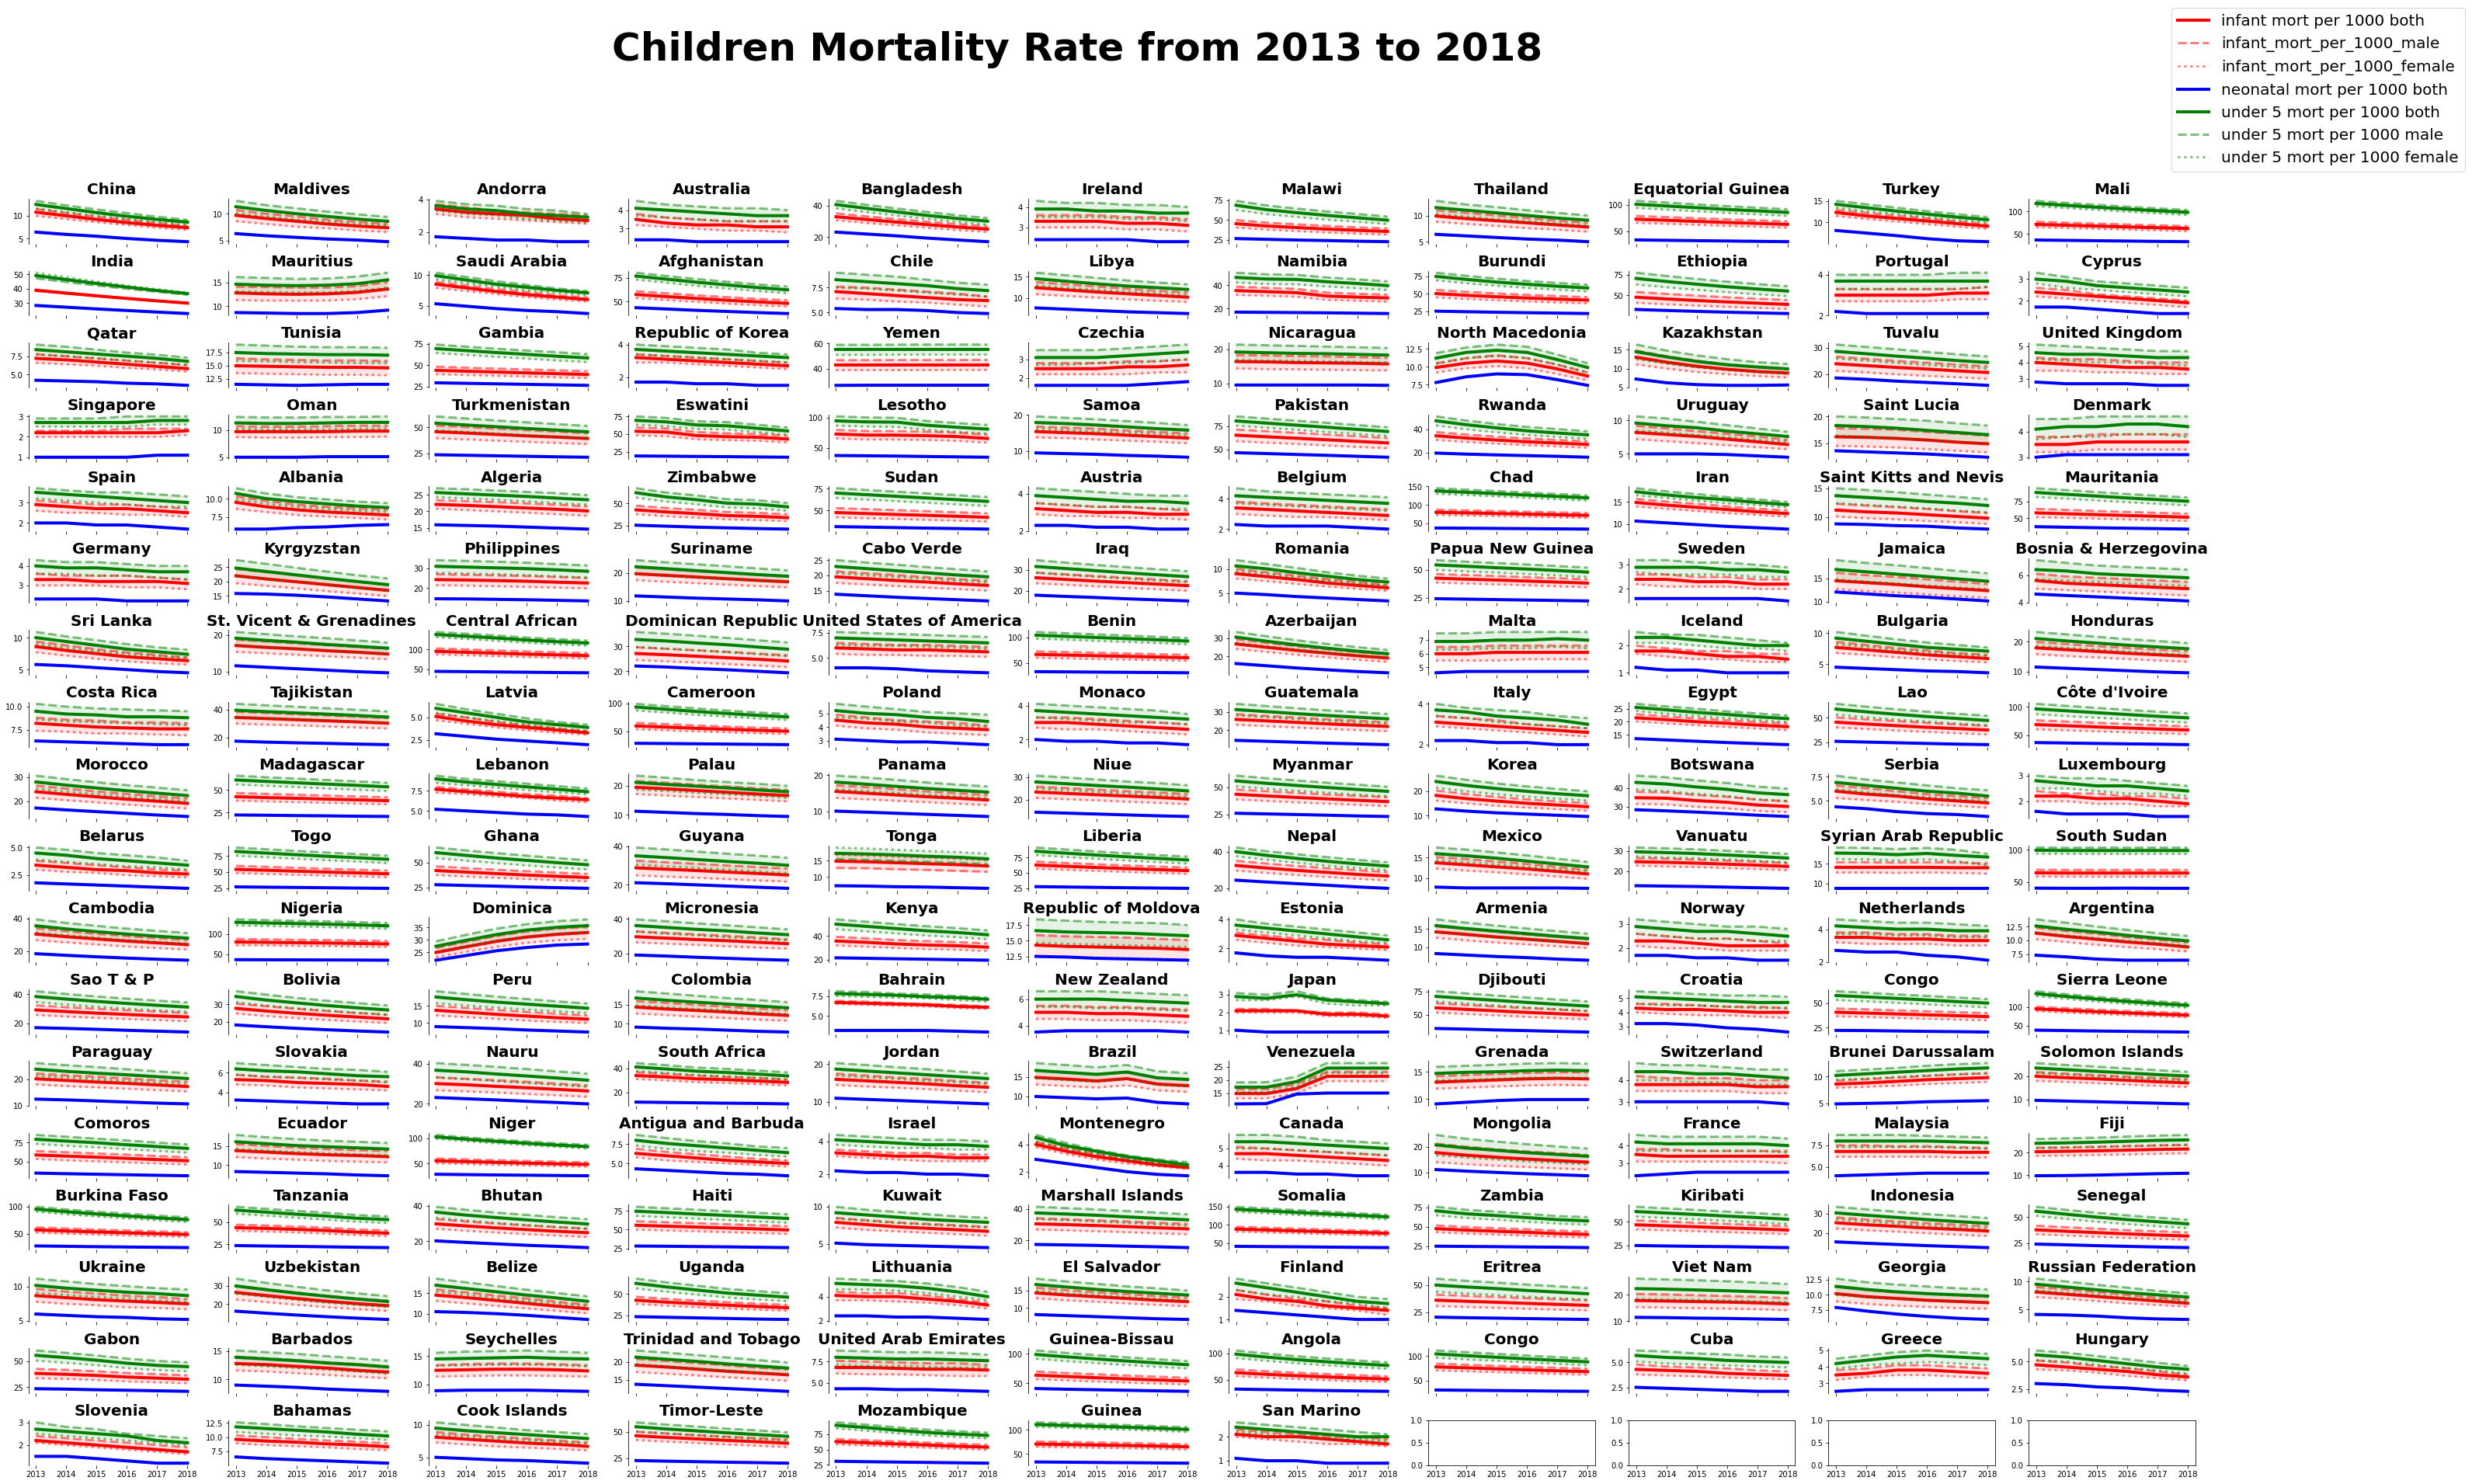

In [30]:
ncols = 11
nrows = math.ceil(len(countries) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(50, 30),sharex=True)
plt.subplots_adjust(hspace=0.6)
fig.suptitle("Children Mortality Rate from 2013 to 2018", fontweight = "bold", fontsize=50)

for country, ax in zip(countries, axes.flatten()):
    # Filter data for each country
    country = country[0] 
    df_country = get_country_children(country)  # Select by country name
    t = df_country['Year'].values.tolist()
    infant_b = df_country['Infant_mort_per_1000_both'].values
    infant_m = df_country['Infant_mort_per_1000_male'].values
    infant_f = df_country['Infant_mort_per_1000_female'].values
    neonatal = df_country['Neonatal_mort_per_1000'].values
    under_5_b = df_country['Under_five_mort_per_1000_both'].values
    under_5_m = df_country['Under_five_mort_per_1000_male'].values
    under_5_f = df_country['Under_five_mort_per_1000_female'].values

    ax.plot(t,infant_b, linewidth = 4, color = 'r', 
             linestyle = '-', 
             label = 'infant mort per 1000 both')
    ax.plot(t,infant_m, linewidth = 3, color = 'r', 
             linestyle = 'dashed', alpha = 0.5, 
             label = 'infant_mort_per_1000_male')
    ax.plot(t,infant_f, linewidth = 3, color = 'r', 
             linestyle = 'dotted', alpha = 0.5,
             label = 'infant_mort_per_1000_female')
    ax.fill_between(t, infant_f, infant_m, color = 'r', alpha = 0.1)

    ax.plot(t,neonatal, linewidth = 4, color = 'b',
            label = 'neonatal mort per 1000 both')

    ax.plot(t,under_5_b, linewidth = 4, color = 'g',
             linestyle = '-',
             label = 'under 5 mort per 1000 both')
    ax.plot(t,under_5_m, linewidth = 3, color = 'g',
             linestyle = 'dashed', alpha = 0.5,
             label = 'under 5 mort per 1000 male')
    ax.plot(t,under_5_f, linewidth = 3, color = 'g',
             linestyle = 'dotted', alpha = 0.5,
             label = 'under 5 mort per 1000 female')
    ax.fill_between(t, under_5_m, under_5_f, color = 'g',alpha=0.1)

    ax.set_title(shorten[country] if country in shorten else country, 
                 fontweight="bold", size=20) # Title
    ax.grid(False)
    #ax.axis('off')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',prop={'size': 20})
plt.show()

In [31]:
#plot on map
def plot_map_by_year_children(year, feature):
    year_df = get_year_children(year)
    fig = px.choropleth(year_df, locations="Country", 
                        locationmode='country names', 
                        color=feature, 
                        hover_name="Country", 
                        range_color=[np.percentile(year_df[feature],25),np.percentile(year_df[feature],75)], 
                        color_continuous_scale="blues", 
                        title = str(year) + ' ' +feature )
    fig.update(layout_coloraxis_showscale=True, layout_width = 1000, layout_height = 700)
    fig.show()
    
plot_map_by_year_children(2015, 'Under_five_mort_per_1000_both')
